# Consistency of varifold kernel selection procedure

Here we use a [decimation-based automatic varifold kernel selection](https://geometric-intelligence.github.io/polpo/_generated/notebooks/how_to/varifold_kernel_tuning.html) and show [decimation impacts the results dramatically](https://geometric-intelligence.github.io/polpo/_generated/notebooks/tutorials/varifold_decimation.html).

This motivates the use of a [characteristic lengths-based approach](https://geometric-intelligence.github.io/polpo/_generated/notebooks/how_to/varifold_kernel_charlen.html).

In [58]:
import random

import numpy as np
import polpo.preprocessing.dict as ppdict
import pyvista as pv
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaBisecSearch
from polpo.plot.pyplot import grouped_barplot
from polpo.preprocessing import BranchingPipeline, IdentityStep
from polpo.preprocessing.load.fsl import get_all_first_structs
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader, get_subject_ids
from polpo.preprocessing.mesh.decimation import PvDecimate

In [2]:
DEBUG = False
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
REF_VALUE = 0.1
STRUCTS = get_all_first_structs(include_brstem=False, order=True)
DERIVATIVE = "enigma"
N_SAMPLES = 5 if not DEBUG else 3

SUBJECT_IDS = sorted(get_subject_ids(include_pilot=True, include_male=False))

In [4]:
if DEBUG:
    SUBJECT_IDS = random.sample(list(SUBJECT_IDS), k=2)
    STRUCTS = random.sample(STRUCTS, k=2)
    TARGET_REDUCTION = 0.8

In [62]:
tab10_cmap = plt.get_cmap("tab10")
colors = [tab10_cmap(i) for i in range(len(STRUCTS) // 2)]

structs_cmap = ListedColormap(colors)

## Data loading

In [5]:
mesh_loader = (
    MeshLoader(
        subject_subset=SUBJECT_IDS,
        struct_subset=STRUCTS,
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.DictMap(ppdict.NestedDictSwapper())
    + ppdict.NestedDictMap(PvSurface, depth=2)
)

raw_meshes = mesh_loader()

In [6]:
decimation_targets = [0.8, 0.5, 0.2, 0]


multi_decimation_pipe = BranchingPipeline(
    [
        (
            ppdict.NestedDictMap(
                PvDecimate(target_reduction=target_reduction, volume_preservation=True)
                + PvSurface,
            )
            if target_reduction
            else IdentityStep()
        )
        for target_reduction in decimation_targets
    ],
    merger=lambda data: dict(zip(decimation_targets, data)),
)

decimated_meshes = ppdict.DictMap(multi_decimation_pipe)(raw_meshes)

2025-11-03 16:13:35.619 (   7.582s) [    72F5F23AC440]            vtkMath.cxx:509   WARN| Unable to factor linear system
2025-11-03 16:13:38.655 (  10.619s) [    72F5F23AC440]            vtkMath.cxx:509   WARN| Unable to factor linear system
2025-11-03 16:13:40.838 (  12.801s) [    72F5F23AC440]            vtkMath.cxx:509   WARN| Unable to factor linear system


Quick viz.

In [7]:
subject_id = random.choice(SUBJECT_IDS)
session_key = random.choice(list(raw_meshes[subject_id][random.choice(STRUCTS)].keys()))

n_vertices = {
    struct_name_: [
        decimated_meshes[subject_id][decimation_target][struct_name_][
            session_key
        ].n_points
        for decimation_target in decimation_targets
    ]
    for struct_name_ in STRUCTS
}

subject_id, n_vertices

('1009B',
 {'L_Accu': [187, 466, 744, 930],
  'L_Amyg': [275, 685, 1094, 1368],
  'L_Caud': [502, 1252, 2002, 2502],
  'L_Hipp': [502, 1252, 2002, 2502],
  'L_Pall': [252, 628, 1003, 1254],
  'L_Puta': [502, 1252, 2002, 2502],
  'L_Thal': [502, 1252, 2002, 2502],
  'R_Accu': [187, 466, 744, 930],
  'R_Amyg': [275, 685, 1094, 1368],
  'R_Caud': [502, 1252, 2002, 2502],
  'R_Hipp': [502, 1252, 2002, 2502],
  'R_Pall': [252, 628, 1003, 1254],
  'R_Puta': [502, 1252, 2002, 2502],
  'R_Thal': [502, 1252, 2002, 2502]})

## Computations

In [8]:
grid_search = SigmaBisecSearch(
    ref_value=REF_VALUE,
    decimator=True,
)

sigmas = {}

### 1 mesh

In [9]:
# NB: ~2min if 4 subjects and 2 structs
n_meshes = 1
sigmas_ = sigmas[n_meshes] = {}

for subject_id, decimated_meshes_ in decimated_meshes.items():
    subject_dict = sigmas_[subject_id] = {}

    for group_id, struct_meshes in decimated_meshes_.items():
        struct_dict = subject_dict[group_id] = {}

        for struct_name, session_meshes in struct_meshes.items():
            session_dict = struct_dict[struct_name] = {}
            session_keys = list(session_meshes.keys())

            replace = True if n_meshes * N_SAMPLES > len(session_keys) else False

            session_subset = np.random.choice(
                session_keys, n_meshes * N_SAMPLES, replace=replace
            ).reshape(n_meshes, -1)

            for sessions in session_subset:
                grid_search.fit([session_meshes[session_id] for session_id in sessions])
                session_dict[tuple(sessions.tolist())] = grid_search.sigma_

/home/luisfpereira/Repos/github/polpo/polpo/mesh/varifold/tuning.py:255: UserWarning: No convergence. Upper interval bound is too strict.
  warnings.warn("No convergence. Upper interval bound is too strict.")


### 2 meshes

In [10]:
# NB: ~4min if 4 subjects and 2 structs
n_meshes = 2
sigmas_ = sigmas[n_meshes] = {}

for subject_id, decimated_meshes_ in decimated_meshes.items():
    subject_dict = sigmas_[subject_id] = {}

    for group_id, struct_meshes in decimated_meshes_.items():
        struct_dict = subject_dict[group_id] = {}

        for struct_name, session_meshes in struct_meshes.items():
            session_dict = struct_dict[struct_name] = {}
            session_keys = list(session_meshes.keys())

            replace = True if n_meshes * N_SAMPLES > len(session_keys) else False

            session_subset = np.random.choice(
                session_keys, n_meshes * N_SAMPLES, replace=replace
            ).reshape(n_meshes, -1)

            for sessions in session_subset:
                grid_search.fit([session_meshes[session_id] for session_id in sessions])
                session_dict[tuple(sessions.tolist())] = grid_search.sigma_

2025-11-03 16:25:22.246 ( 714.209s) [    72F5F23AC440]            vtkMath.cxx:509   WARN| Unable to factor linear system


### All

In [11]:
# NB: ~8min if 4 subjects and 2 structs
sigmas_ = sigmas[-1] = {}

for subject_id, decimated_meshes_ in decimated_meshes.items():
    subject_dict = sigmas_[subject_id] = {}

    for group_id, struct_meshes in decimated_meshes_.items():
        struct_dict = subject_dict[group_id] = {}

        for struct_name, session_meshes in struct_meshes.items():
            session_dict = struct_dict[struct_name] = {}
            sessions = list(session_meshes.keys())

            grid_search.fit([session_meshes[session_id] for session_id in sessions])
            session_dict[tuple(sessions)] = grid_search.sigma_

2025-11-03 16:47:59.199 (2071.162s) [    72F5F23AC440]            vtkMath.cxx:509   WARN| Unable to factor linear system


## Per subject: target reduction, structure

### 1 mesh

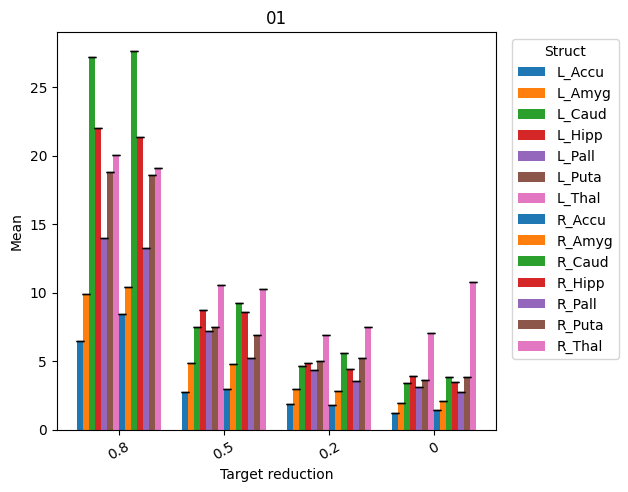

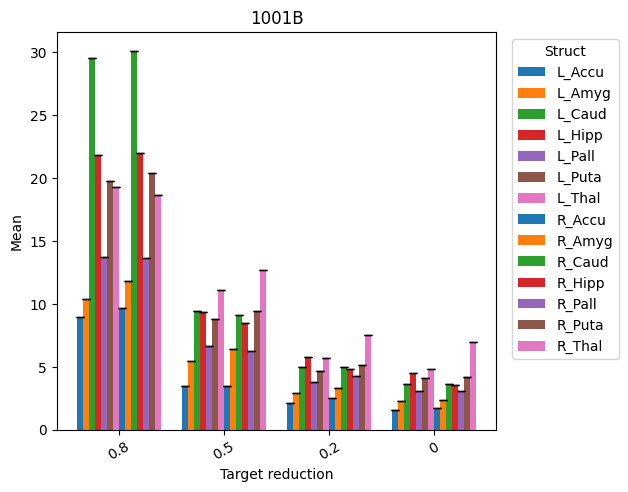

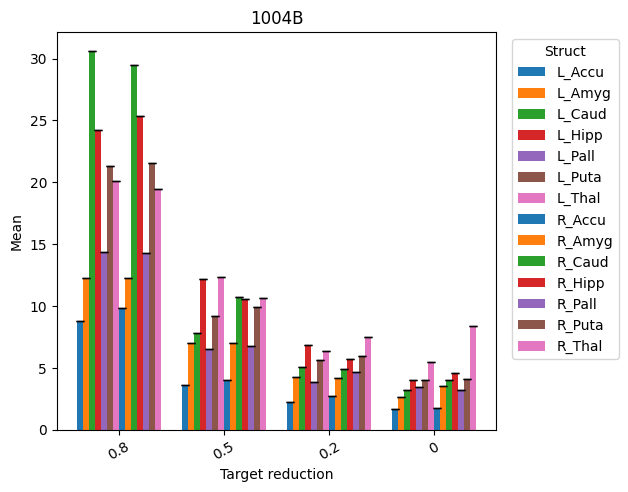

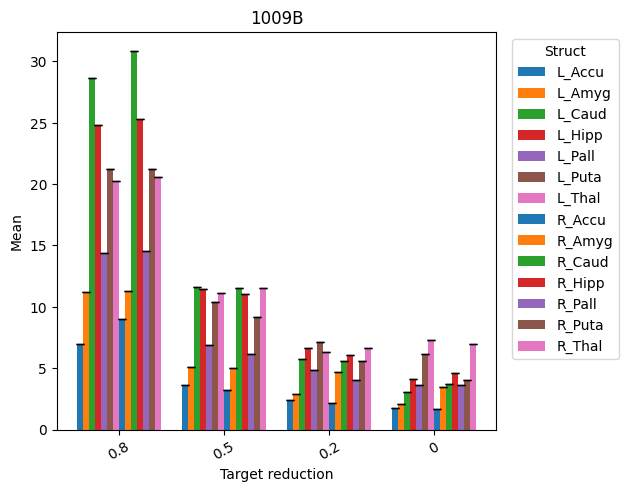

In [65]:
for subject_id, decimation_sigmas in sigmas[1].items():
    sigmas_ = ppdict.NestedDictMap(ppdict.DictToValuesList())(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap)

    ax.set_xlabel("Target reduction")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

### 2 meshes

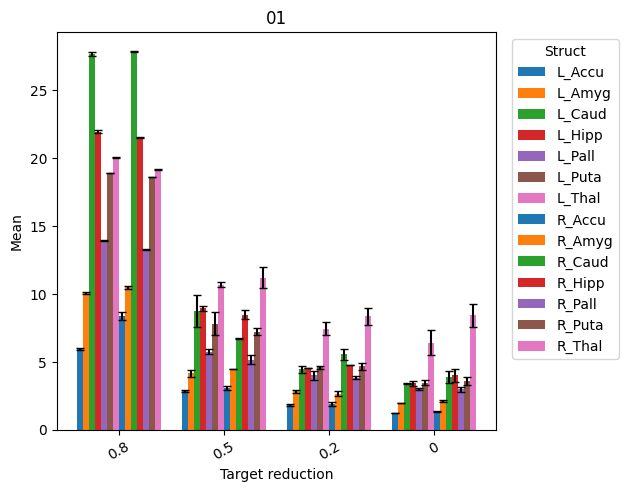

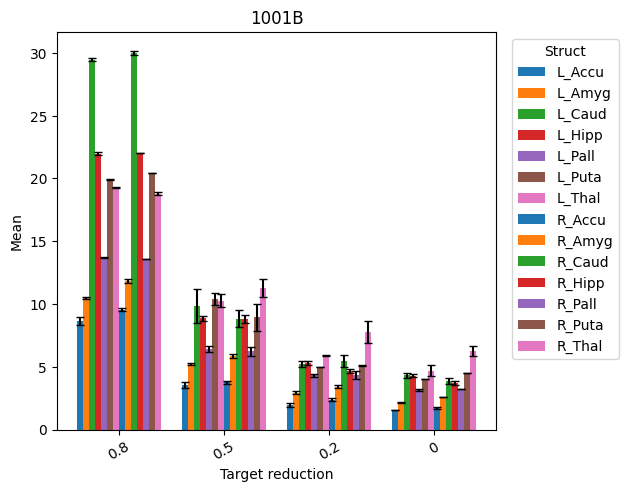

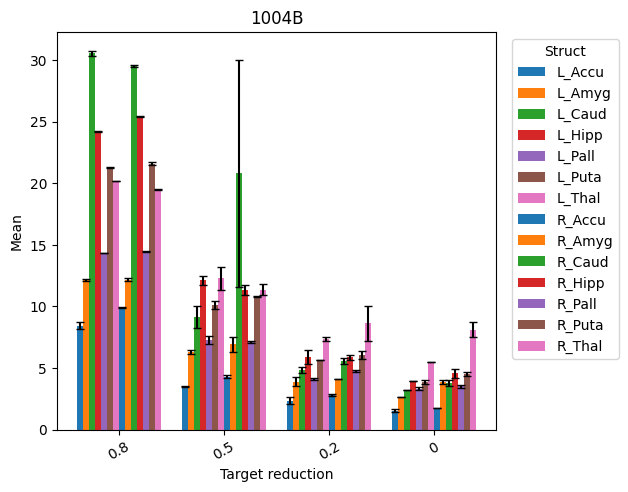

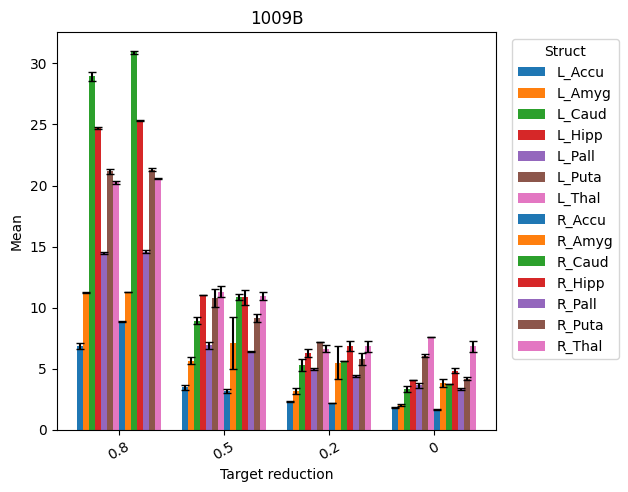

In [66]:
for subject_id, decimation_sigmas in sigmas[2].items():
    sigmas_ = ppdict.NestedDictMap(ppdict.DictToValuesList())(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap)

    ax.set_xlabel("Target reduction")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

### All

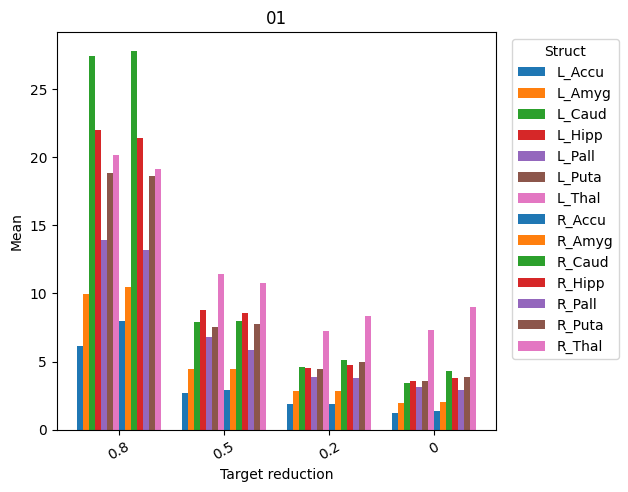

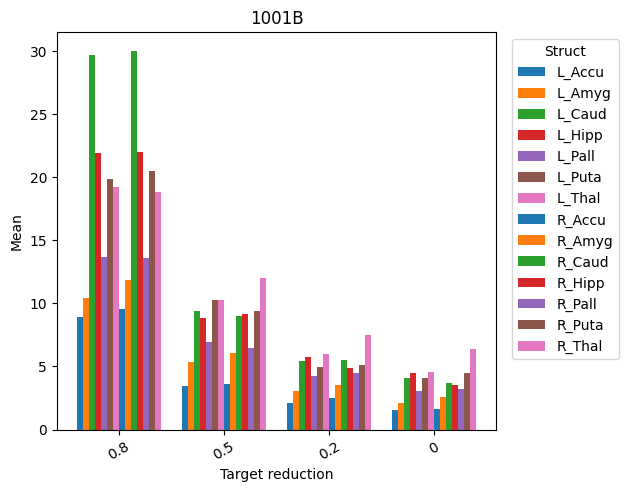

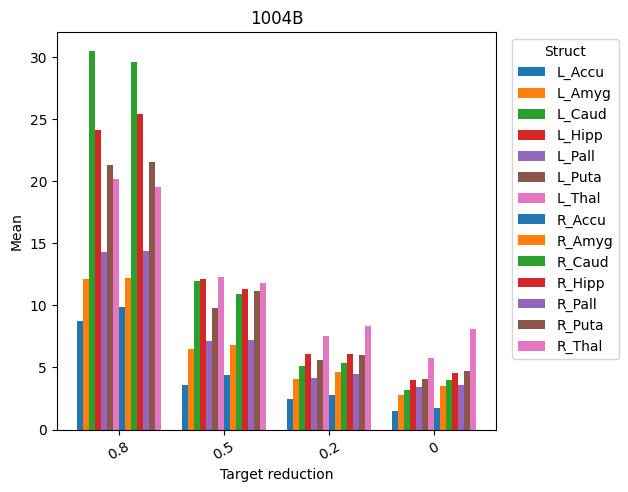

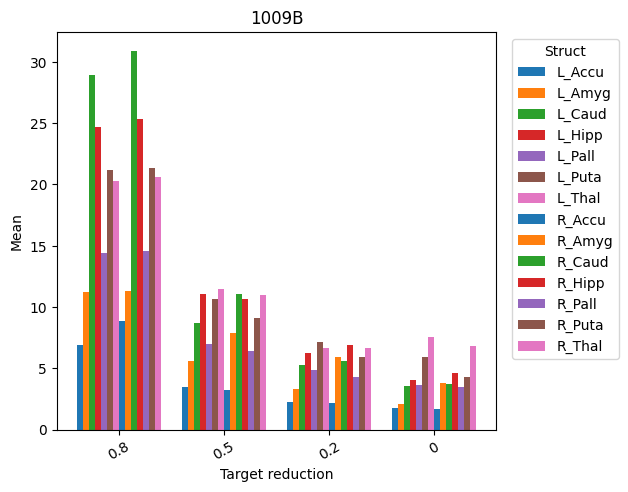

In [67]:
for subject_id, decimation_sigmas in sigmas[-1].items():
    sigmas_ = ppdict.NestedDictMap(ppdict.DictToValuesList())(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap, show_std=False)

    ax.set_xlabel("Target reduction")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

## Per subject: structure, target reduction

### 1 mesh

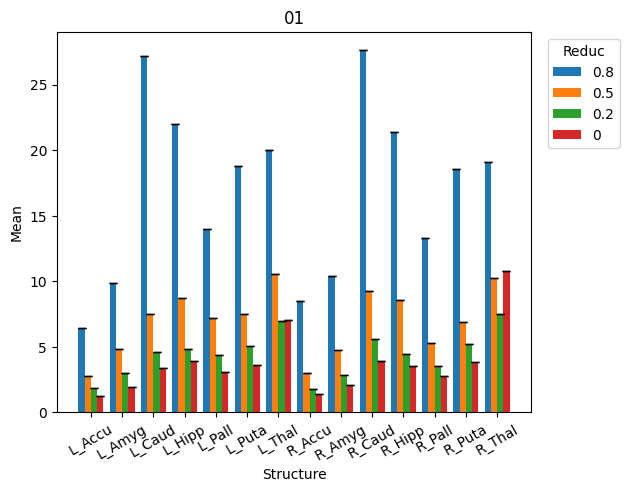

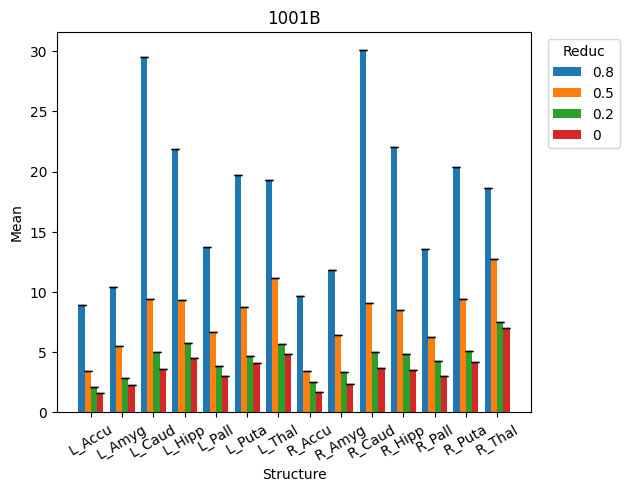

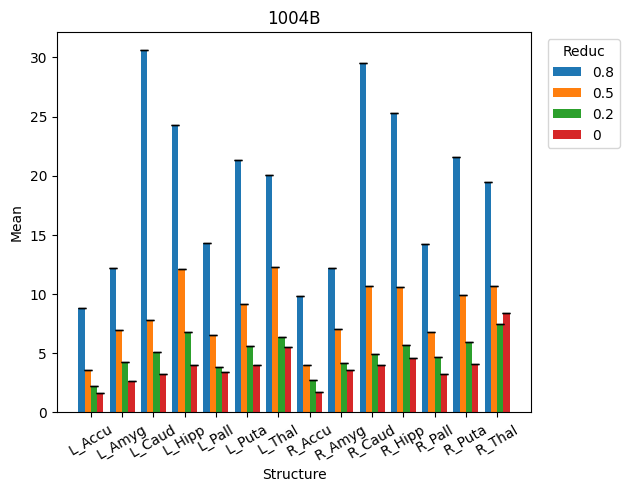

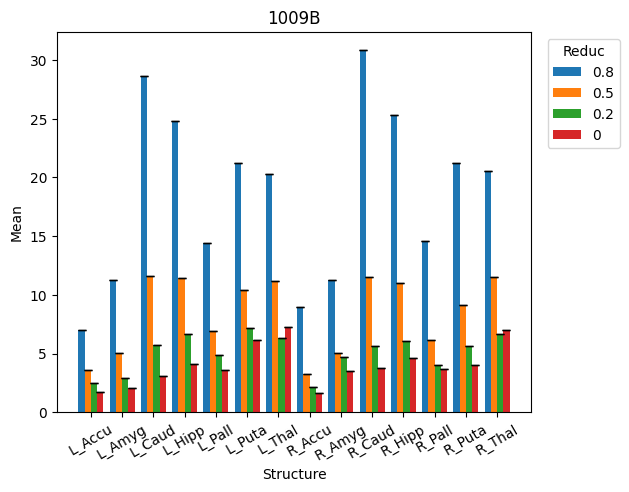

In [24]:
for subject_id, decimation_sigmas in sigmas[1].items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

### 2 meshes

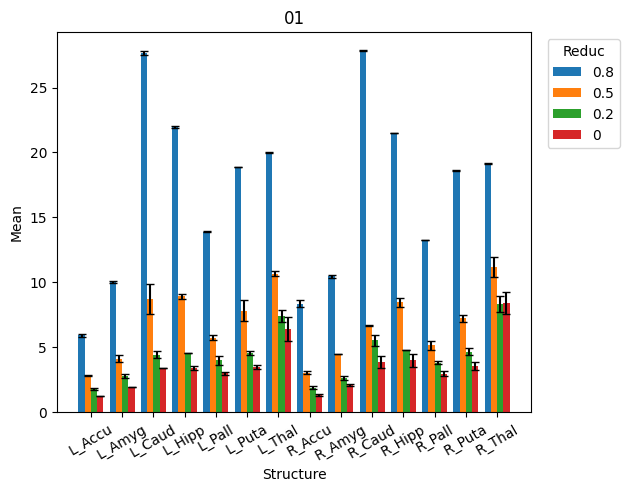

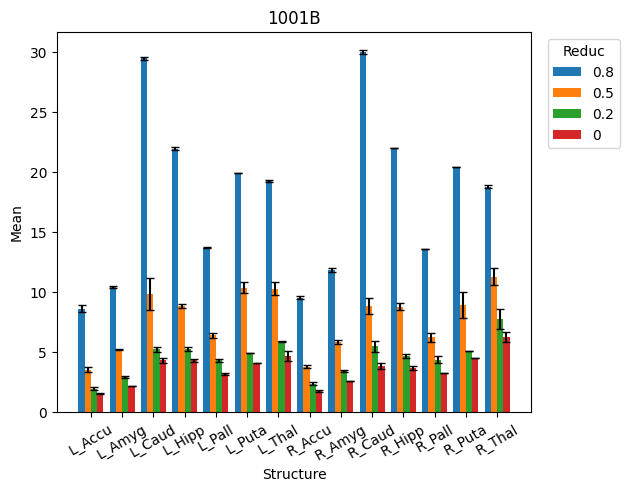

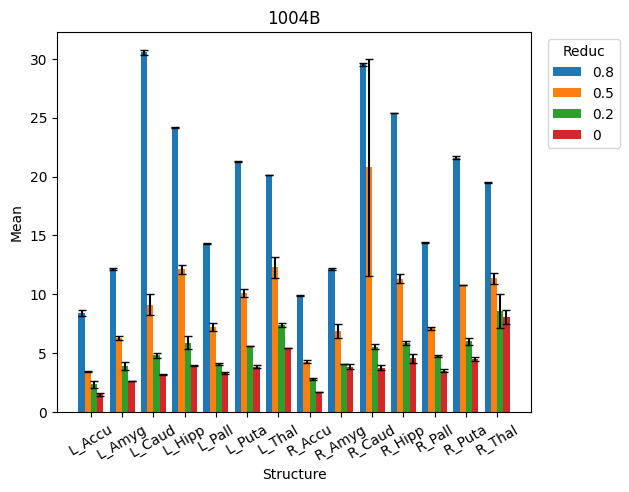

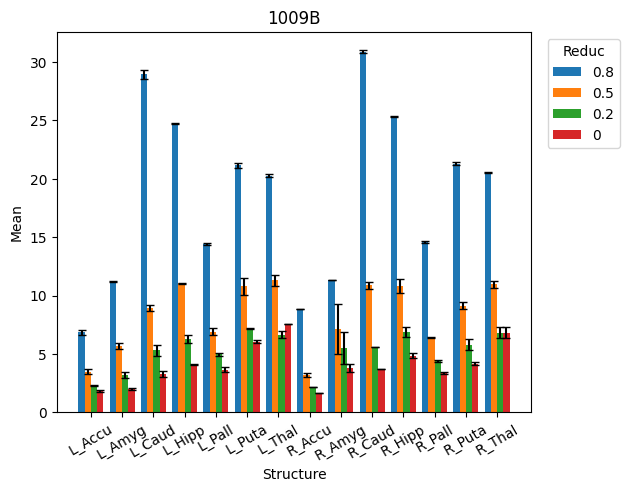

In [25]:
for subject_id, decimation_sigmas in sigmas[2].items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

### All

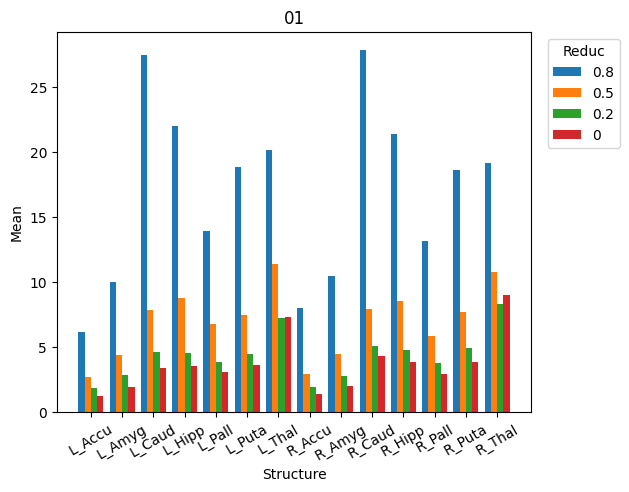

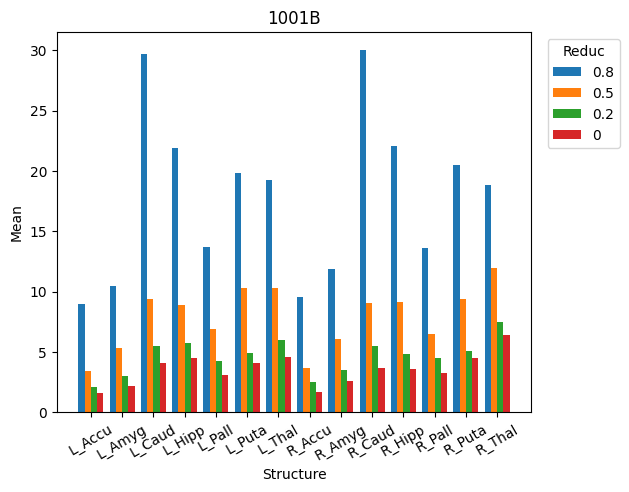

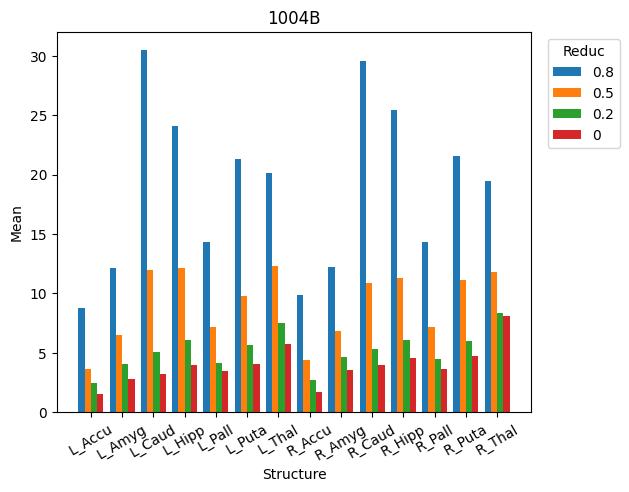

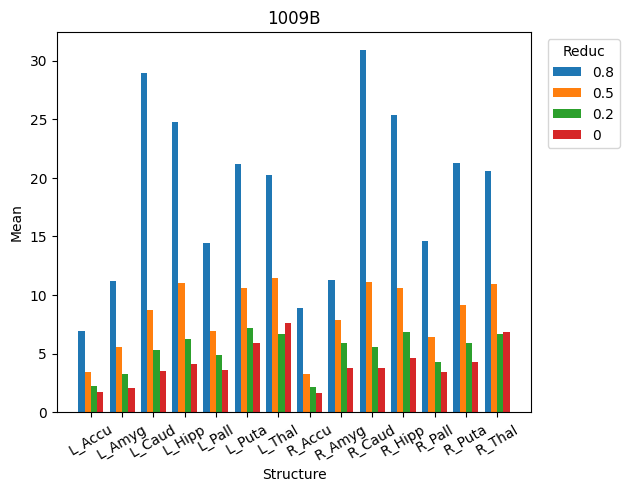

In [26]:
for subject_id, decimation_sigmas in sigmas[-1].items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_, show_std=False)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Reduc", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{subject_id}")
    plt.show()

## Per target reduction: subject, structure

### 1 mesh

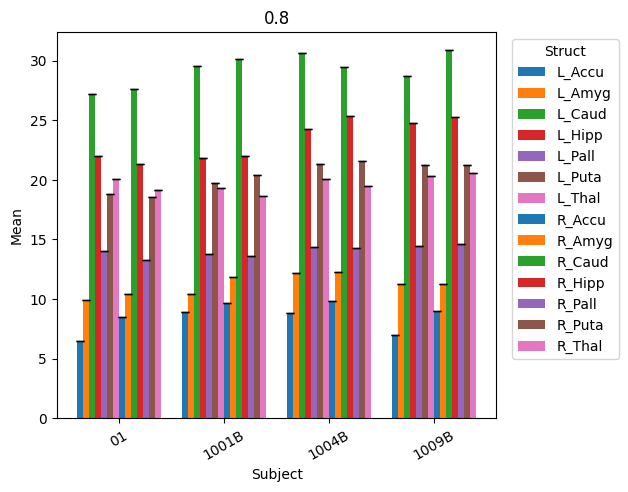

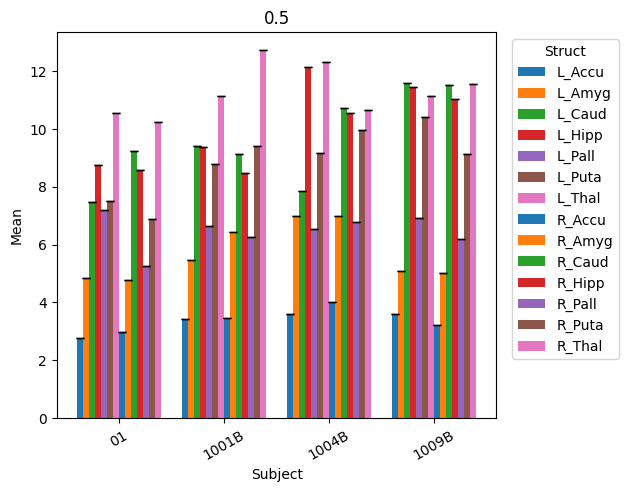

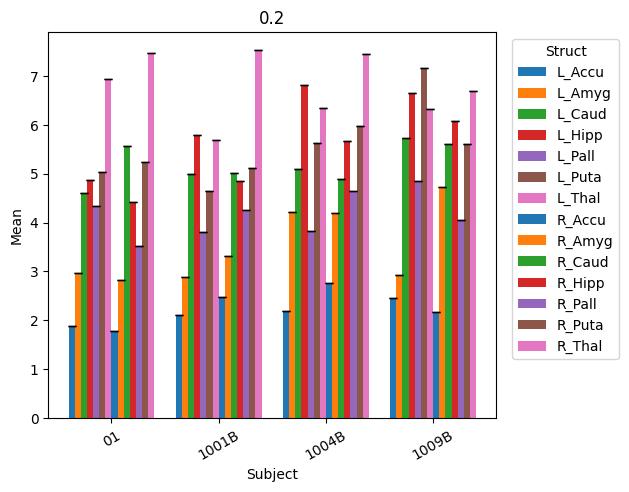

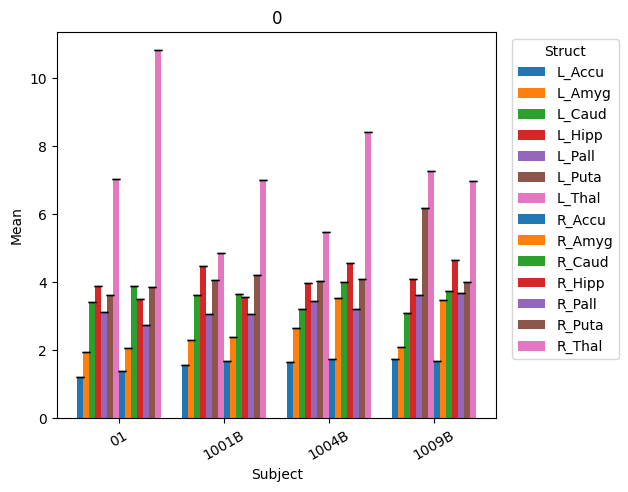

In [68]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[1]).items():
    sigmas_ = (ppdict.NestedDictMap(ppdict.DictToValuesList()))(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap)

    ax.set_xlabel("Subject")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()

### 2 meshes

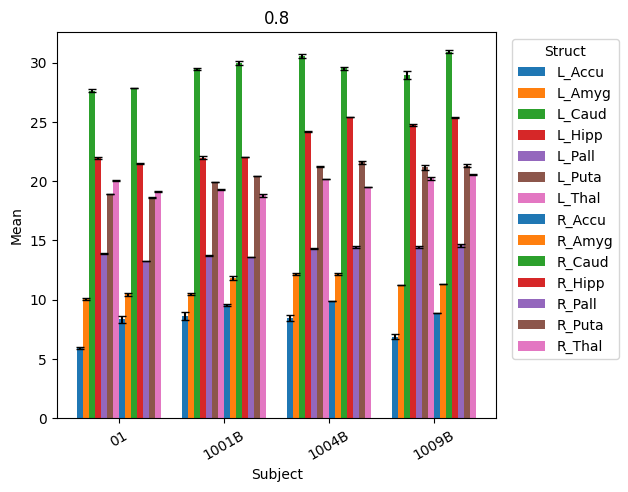

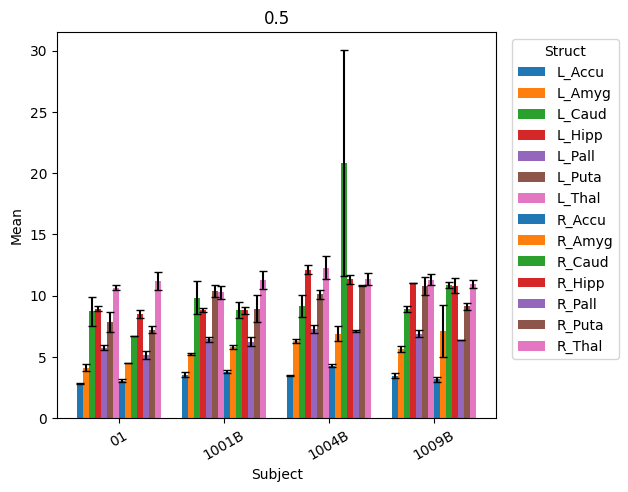

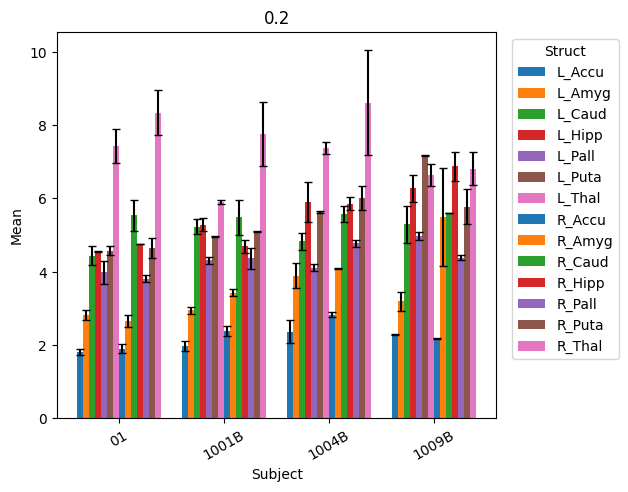

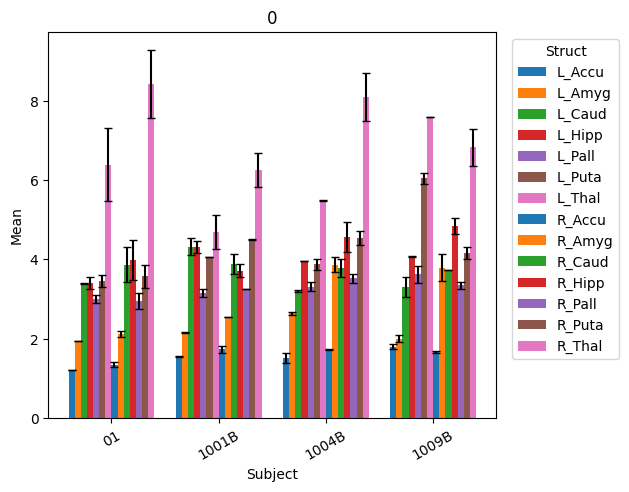

In [69]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[2]).items():
    sigmas_ = (ppdict.NestedDictMap(ppdict.DictToValuesList()))(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap)

    ax.set_xlabel("Subject")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()

### All

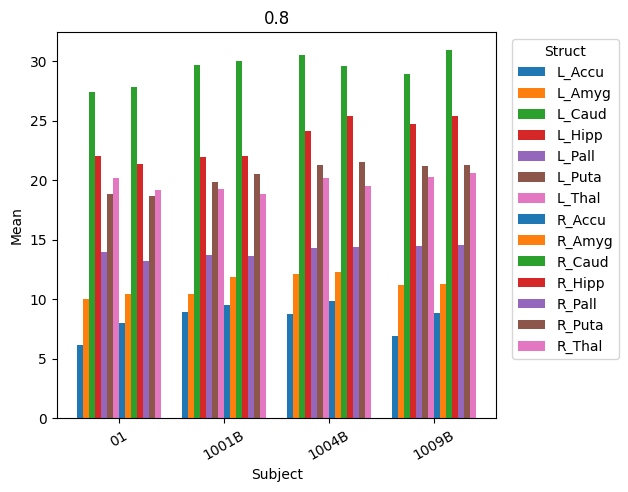

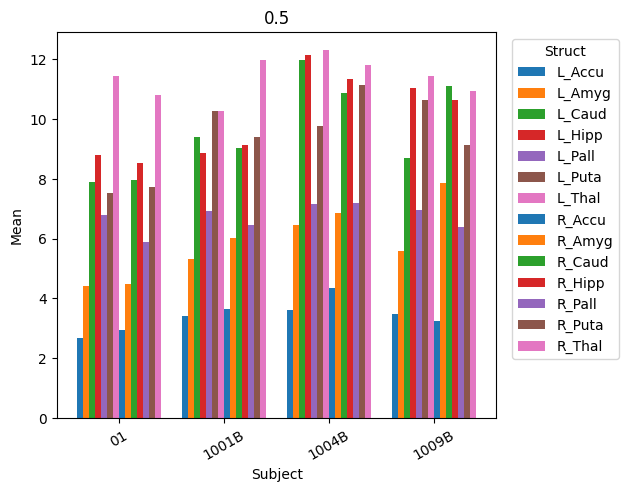

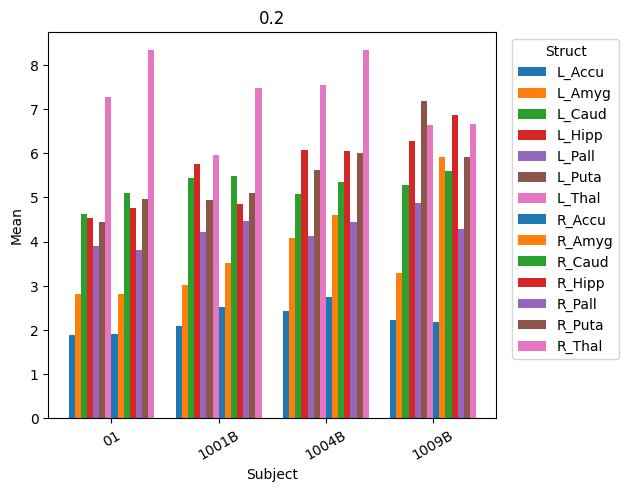

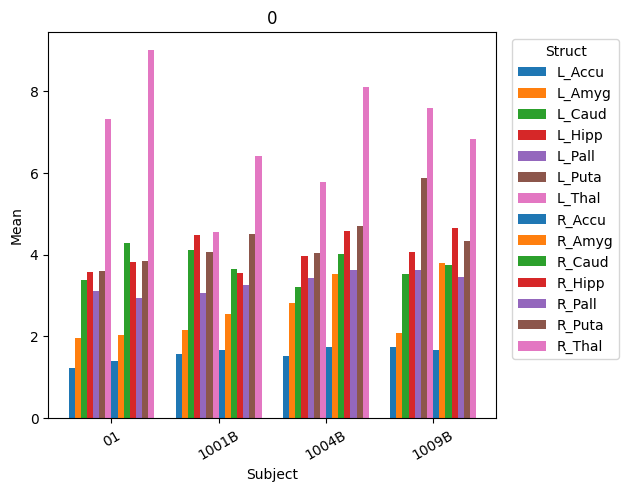

In [70]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[-1]).items():
    sigmas_ = (ppdict.NestedDictMap(ppdict.DictToValuesList()))(decimation_sigmas)

    ax = grouped_barplot(sigmas_, cmap=structs_cmap, show_std=False)

    ax.set_xlabel("Subject")
    ax.set_ylabel("Mean")

    ax.legend(title="Struct", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()

## Per target reduction: structure, subject

### 1 mesh

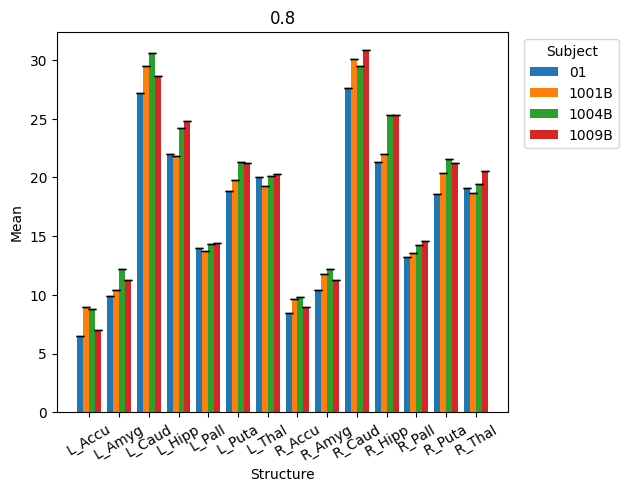

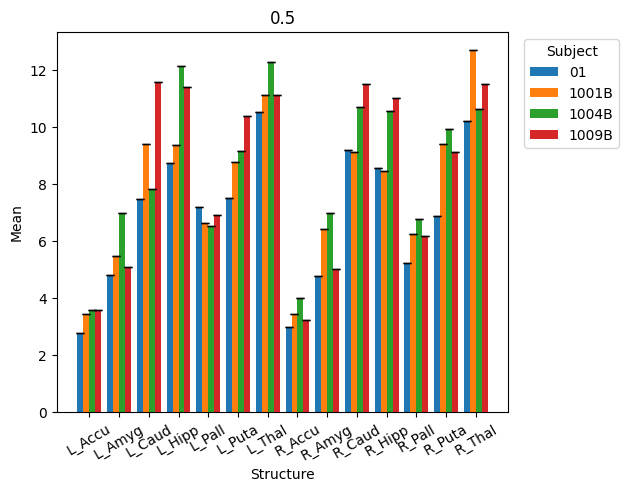

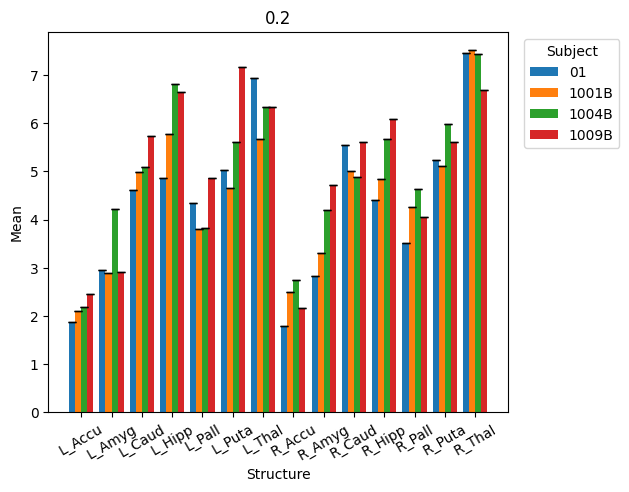

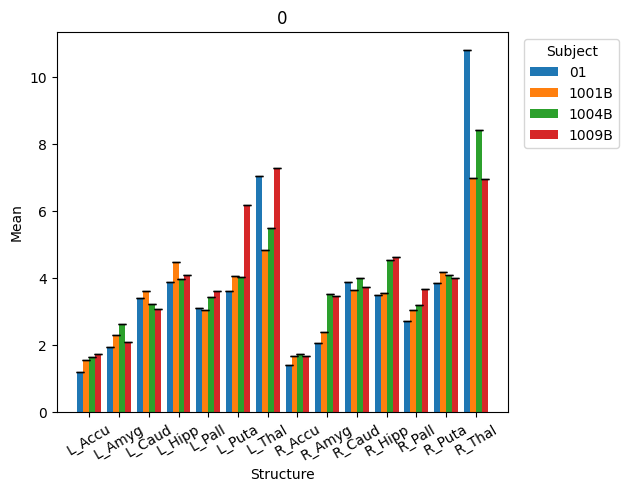

In [34]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[1]).items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Subject", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()

### 2 meshes

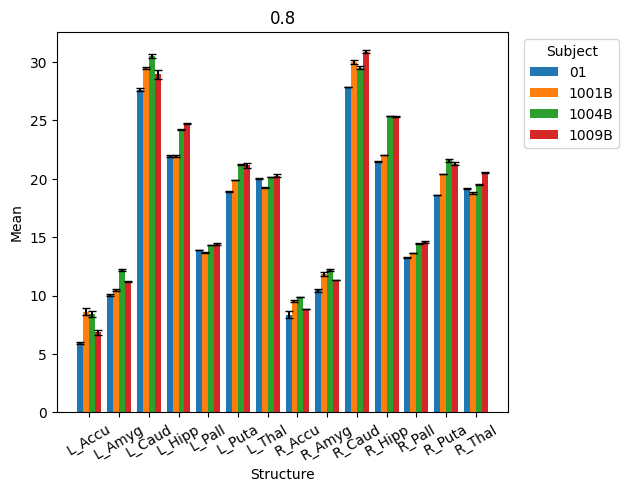

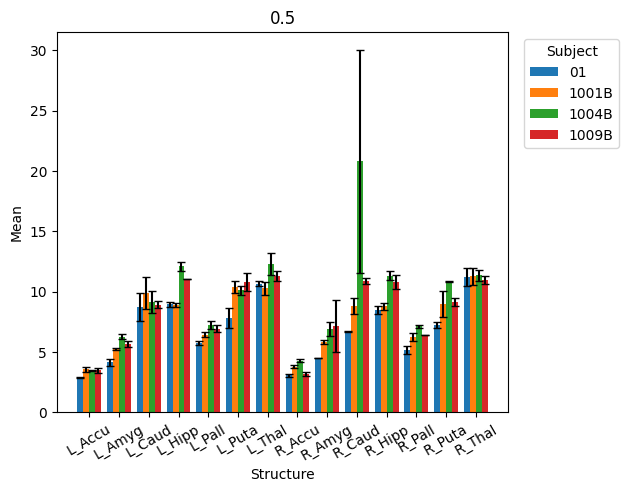

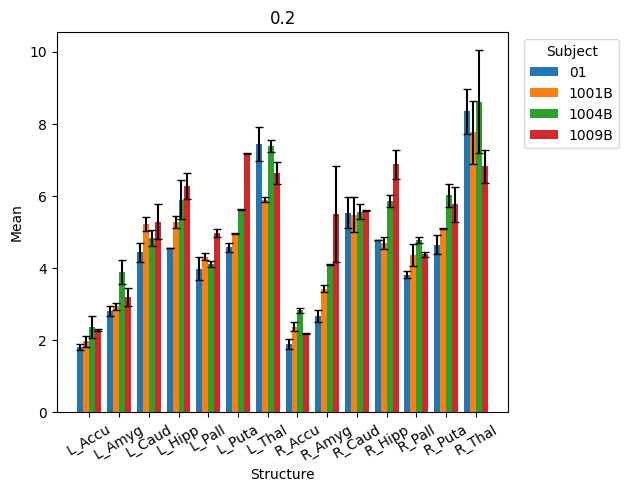

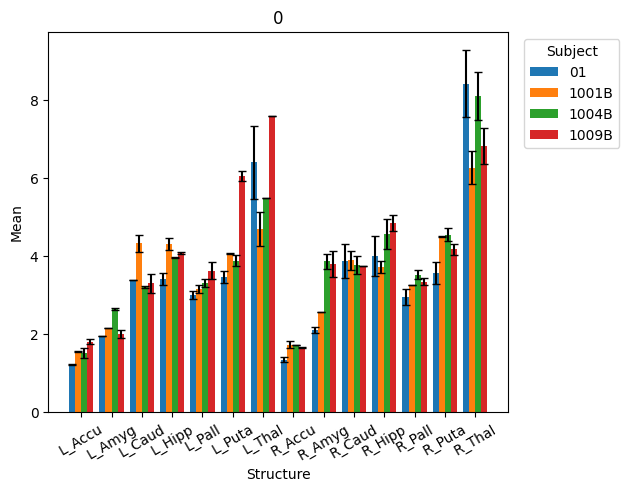

In [35]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[2]).items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Subject", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()

### All

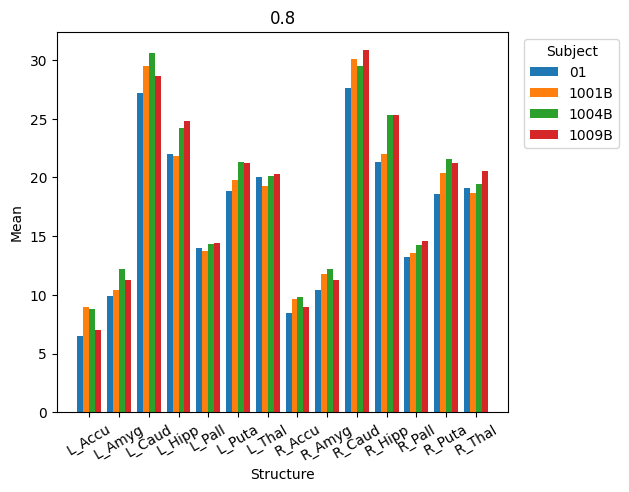

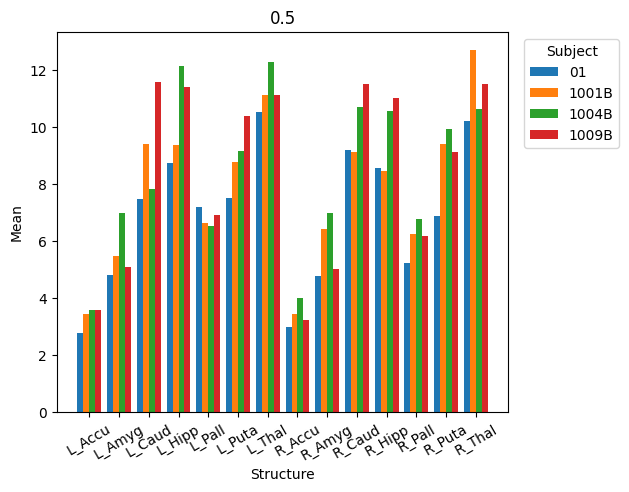

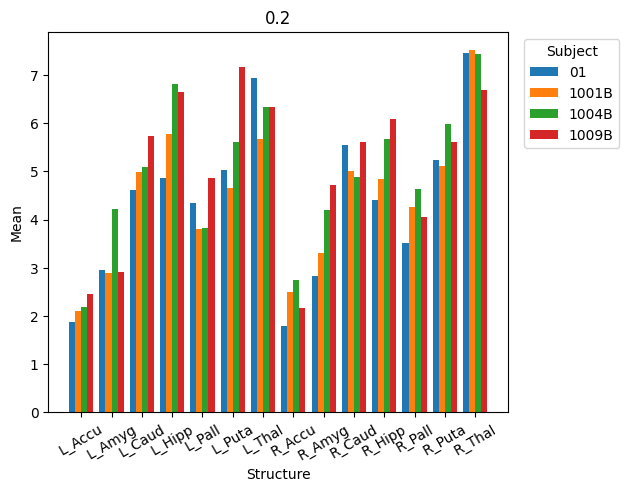

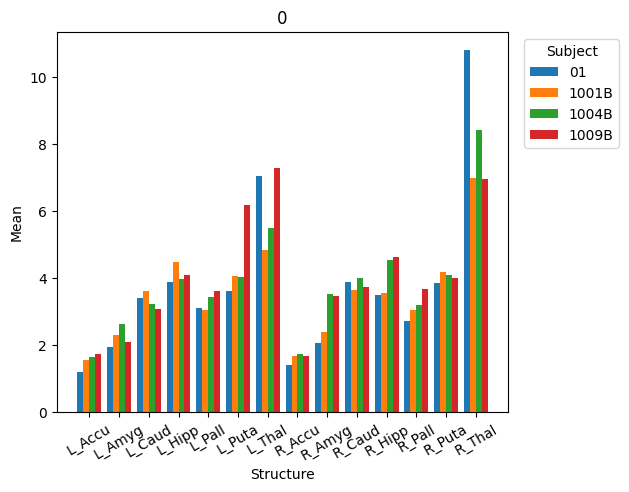

In [36]:
for group_id, decimation_sigmas in ppdict.NestedDictSwapper()(sigmas[1]).items():
    sigmas_ = (
        ppdict.NestedDictSwapper() + ppdict.NestedDictMap(ppdict.DictToValuesList())
    )(decimation_sigmas)

    ax = grouped_barplot(sigmas_, show_std=False)

    ax.set_xlabel("Structure")
    ax.set_ylabel("Mean")

    ax.legend(title="Subject", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    ax.set_title(f"{group_id}")
    plt.show()